## 0. File uncompressing

In [1]:
!mkdir ./test/
!tar -xf ./muct-b-jpg-v1.tar.gz -C ./test

In [2]:
import os
import pandas as pd

def get_files_list(path):
    '''
       Return the file list given a path using the linux command called 'tree'
       Args: 
           path: String
               the path to get the files list
    '''
    init_list=!tree -a -f -R -i $path 
    files=[]
    for f in init_list:
        #if isn't a directory or a jupyter notebook append to the file list
        if not(os.path.isdir(f)) and ('ipynb' not in f):
            files.append(f)
    files = files[0:-2]
    files = [x.split('/')[-1] for x in files]#get only the filename
    files = [(x, 0) for x in files] #append zero tag to each file
    return pd.DataFrame(data=files, columns=["file", "is_showing_theets"]) #convert the list to pandas dataframe 
    

___
## 5. Prediction

Once the trainig phase has ended, just need to classify the test images that our network never has seen before.

### 5.1 Load final weights
Ensure that the weights that use the model has the best the network could find.

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K
from keras.layers import Dense, Flatten, Input, Dropout
from keras.models import Model
import numpy as np


def get_input_shape(img_rows=224, img_cols = 224):
    '''
        Helper function that organize the inputs taking into account if is runing into a tensorflow or theano backend
    '''
    if K.image_dim_ordering() == 'th':
        input_shape = (3, img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, 3)
    return Input(shape=input_shape)  

#model construction
base_model = ResNet50(include_top=False, input_tensor=get_input_shape()) #use resnet as base model and imagenet weights
x = base_model.output
x = Flatten()(x) #flat the tensor to a 1-d vector
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='sigmoid')(x)#append at the end of the network the classifier
model = Model(input=base_model.input, output=x) #the final model
#load final weights
model.load_weights('weights_fine_tunning.h5')

Using TensorFlow backend.


### 5.2 Predict and move files
Now we need to perform the prediction of each image of the test set, also given the classification output move each image into one of the folders **0** or **1**. For that task I've created the next function.

In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import shutil
def classify_test_files(working_path = './test/jpg/', batch_size = 10 ):
    if not os.path.exists(working_path+'0/'):
        os.makedirs(working_path+'0/')
    if not os.path.exists(working_path+'1/'):
        os.makedirs(working_path+'1/')
    files=get_files_list('./test/jpg/')
    n_files = len(files.index)
    
    #load the test images and transforms them into array representation
    np_images=[]
    for index in files.index:
        np_images.append(img_to_array(load_img('./test/jpg/'+files.get_value(index, "file"), target_size=(224, 224))))

    #perform the prediction in batches
    for batch in range(np.ceil(n_files/batch_size).astype(np.int32)):
        prediction = model.predict_on_batch(np.array(np_images[batch*batch_size : min(batch*batch_size+batch_size, n_files)]))
        prediction = [1 if x>=0.5 else 0 for x in prediction] #map from probability to categories tags
        for index in range(len(prediction)):
            files.set_value(batch*batch_size+index, 'is_showing_theets', prediction[index])
            
    #move test files into folders
    for i in files.values:
        if i[1]==0:
            shutil.move(working_path+i[0], working_path+'0/')
        else:
            shutil.move(working_path+i[0], working_path+'1/')
    return files

In [5]:
classification_results = classify_test_files()
classification_results.sample(5)

,file,is_showing_theets
673,i438wb-mn.jpg,0
552,i293tb-fn.jpg,1
309,i212tb-fn.jpg,0
155,i051sb-fn.jpg,1
503,i276vb-mn.jpg,0


### 5.3 Sampling from predictions
Now for the sake of illustration sample and show some images for each category.
#### 5.3.1 Showing Teeth Sample

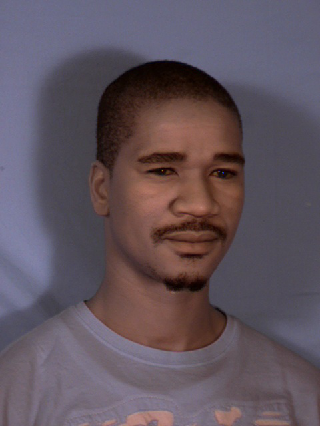

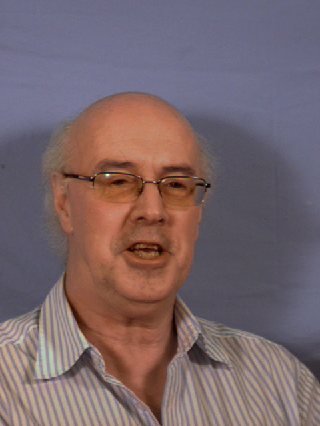

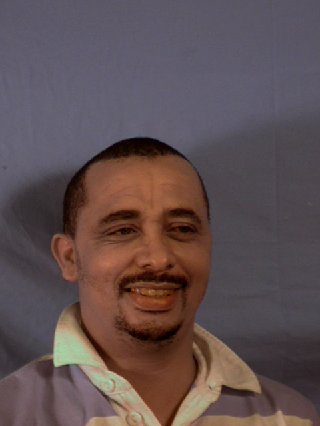

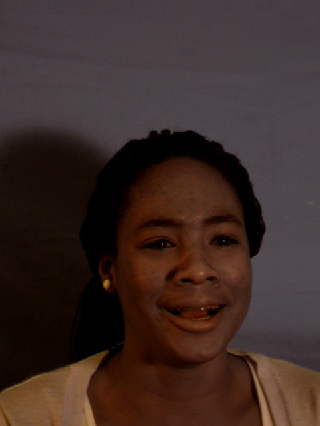

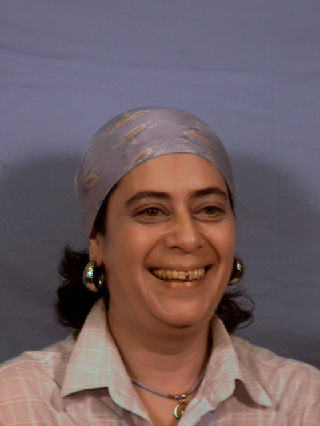

In [6]:
from IPython.display import display
samples = classification_results[classification_results.is_showing_theets==1].sample(5)['file']
for sample in samples:
    display(load_img('./test/jpg/1/'+sample, target_size=(426, 320)))

#### 5.3.2 Not Showing Teeth Sample

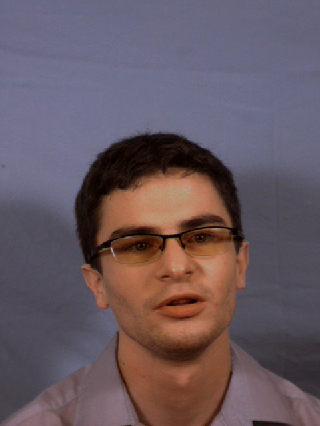

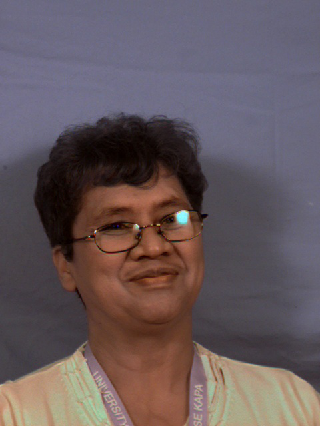

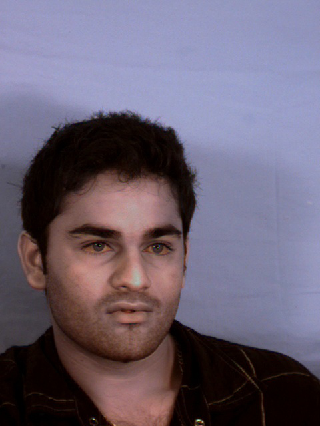

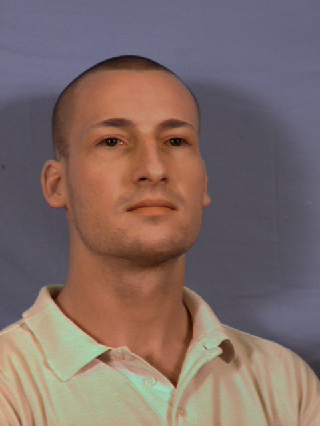

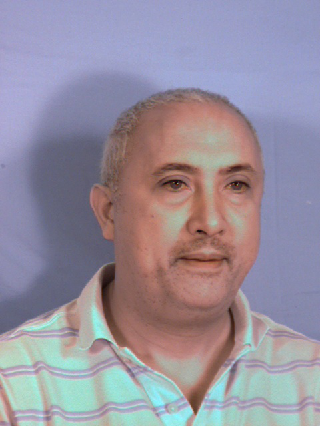

In [7]:
samples = classification_results[classification_results.is_showing_theets==0].sample(5)['file']
for sample in samples:
    display(load_img('./test/jpg/0/'+sample, target_size=(426, 320)))